# Visualizing geographic density

A few approaches to visualizing the density of weighted points on a map. Cribs heavily from Agile Scientific's very cool [blog post](https://agilescientific.com/blog/2017/12/14/no-more-rainbows) on using contour lines, hillshading, and good colormaps to visualize geographic data.

If reproducing, requires a [Mapbox API key](https://www.mapbox.com/help/define-access-token/).

In [1]:
%matplotlib inline

# Imports and settings
import os
import pandas as pd
import numpy as np
from   scipy import ndimage
import matplotlib.pyplot as plt
from   matplotlib.colors import LightSource
from   matplotlib.colors import LinearSegmentedColormap
from   matplotlib.colors import ListedColormap
import cartopy.crs as ccrs # not in base anaconda; conda install -c conda-forge cartopy
from   cartopy.io.img_tiles import *

figDir = 'figures'
inDir  = 'inputs'
os.makedirs(figDir, exist_ok=True)
os.makedirs(inDir, exist_ok=True)

mapbox_key_file = '/Users/mwilkens/Google Drive/Private/mapbox-api-key.txt'
try:
    mapbox_key = open(mapbox_key_file).read().strip()
except:
    print('Cannot get Mapbox API key. This will go badly.')

plt.rc('figure', figsize=(16, 12))

## Data

Load sample data and take a glance at it. FWIW, this is a subset of places mentioned in novels about London, weighted by length-normalized occurrence count.

In [2]:
# Load data
data = pd.read_csv(os.path.join(inDir, 'london.csv'))
data.head()

,weight,lat,lon
0,26.846335,51.412330,-0.300689
1,9.822218,51.535638,-0.089344
2,13.027392,51.555684,-0.213960
3,12.687779,51.517881,-0.148101
4,8.116554,51.463034,-0.215990


Group by point and transform to lists.

In [3]:
# Get data into shape for mapping
latlons = data.groupby(['lat', 'lon']).weight.sum()
weights = latlons.tolist()
lons    = latlons.index.get_level_values('lon').tolist()
lats    = latlons.index.get_level_values('lat').tolist()

## Functions

`make_colormap()` and `add_alpha` are lifted directly from Agile's work.

In [4]:
# Functions
def make_colormap(seq):
    """
    Converts a sequence of RGB tuples containing floats in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return LinearSegmentedColormap('CustomMap', cdict)

def add_alpha(cmap, alpha=None):
    """
    Add an alpha channel (opacity) to a colourmap. Uses a ramp by default.
    Pass an array of 256 values to use that. 0 = transparent; 1 = opaque.
    """
    cmap4 = cmap(np.arange(cmap.N))
    if alpha is None:
        alpha = np.linspace(1, 0, cmap.N)
    cmap4[:,-1] = alpha
    return ListedColormap(cmap4)

def heatmap(x, y, z, bins=100, smoothing=1.3, log=False, masklow=0, extent=None):
    '''
    Takes lists of x coordinates and y coordinates, plus list of weights for each point.
    If supplied, extent limits x- and y-ranges over which values are calculated.
    Returns a Gaussian-filtered 2d histogram of weighted points.
    '''
    if extent: # Not just axis limits; calculated values change if extent != min, max
        xmin = extent[0]
        xmax = extent[1]
        ymin = extent[2]
        ymax = extent[3]
    else:
        xmin = min(x)
        xmax = max(x)
        ymin = min(y)
        ymax = max(y)        
    bins = (np.linspace(ymin, ymax, bins), np.linspace(xmin, xmax, bins))
    heatmap, xedges, yedges = np.histogram2d(y, x, weights=z, bins=bins)
    if log: # Log limits high-value blowout, but not always desirable
        logheatmap = np.log(heatmap)
        logheatmap[np.isneginf(logheatmap)] = 0
        heatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    else: 
        heatmap = ndimage.filters.gaussian_filter(heatmap, smoothing, mode='nearest')
    if masklow>0: # Mask low values, makes for better map overlay
        heatmap = np.ma.masked_where(heatmap < masklow, heatmap)
    return heatmap

## Maps

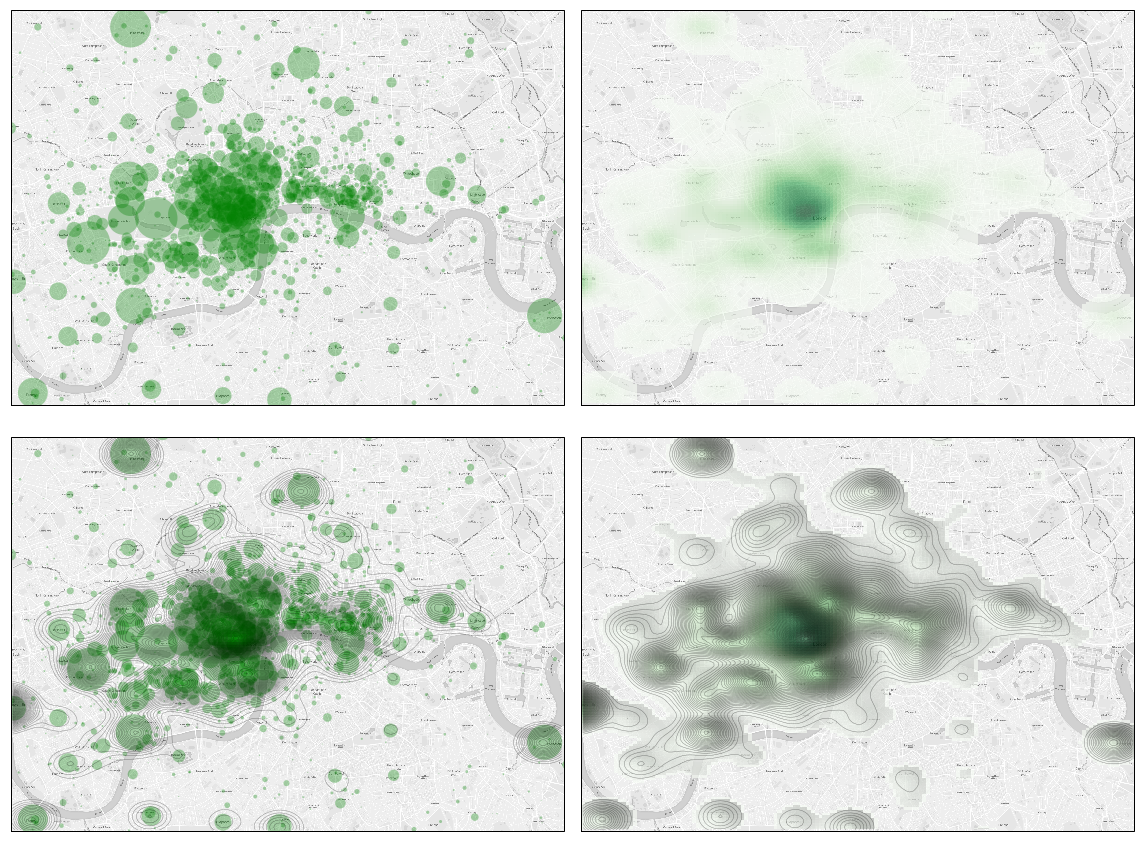

In [5]:
# Set map extent
#  London with relatively tight bounds. 
#  Exact zero values give bad results in heatmap.
extent = [-0.225, 0.00001, 51.46, 51.56] 

# Get map tiles
imagery = MapboxTiles(mapbox_key, 'mapbox.light')

# Heatmap
#  Fiddle with parameters to get different looks
hm = heatmap(lons, lats, weights, bins=150, smoothing=4, log=False, 
             masklow=1, extent=extent)

# Contours
mi, ma = np.floor(np.nanmin(hm)), np.ceil(np.nanmax(hm))
steps = ((ma-mi)/100) # Lots of contours produces a kind of pseudo-hillshade
levels = np.arange(mi, ma, steps)

# Hillshading
ls = LightSource()
bumps = ls.hillshade(hm)
kmap = make_colormap([(0,0,0)])
kmap4 = add_alpha(kmap)

# Base figure
fig = plt.figure(figsize=(16, 12))

# Bubbles
ax1 = fig.add_subplot(221, projection=imagery.crs)
ax1.set_extent(extent, crs=ccrs.PlateCarree())
ax1.add_image(imagery, 14, zorder=1)
ax1.scatter(lons, lats, s=weights, linewidths=0, color='green', marker='o', 
            alpha=0.33, transform=ccrs.Geodetic(), zorder=2)
ax1.axis('off')

# Heatmap
ax2 = fig.add_subplot(222, projection=imagery.crs)
ax2.set_extent(extent, crs=ccrs.PlateCarree())
ax2.add_image(imagery, 14, zorder=1)
ax2.imshow(hm, extent=extent, aspect='auto', cmap='Greens', alpha=0.67, 
           origin='lower', transform=ccrs.PlateCarree(), zorder=2)
ax2.axis('off')

# Bubbles with contours
ax3 = fig.add_subplot(223, projection=imagery.crs)
ax3.set_extent(extent, crs=ccrs.PlateCarree())
ax3.add_image(imagery, 14, zorder=1)
ax3.scatter(lons, lats, s=weights, linewidths=0, color='green', marker='o', 
            alpha=0.33, transform=ccrs.Geodetic(), zorder=2)
ax3.contour(hm, extent=extent, origin='lower', transform=ccrs.PlateCarree(),
            levels=levels, linewidths=0.4, colors=[(0,0,0,0.5)], zorder=3)
ax3.axis('off')

# Complex map - heatmap, hillshade, contours
ax4 = fig.add_subplot(224, projection=imagery.crs)
ax4.set_extent(extent, crs=ccrs.PlateCarree())
ax4.add_image(imagery, 14, zorder=1)
ax4.imshow(hm, extent=extent, aspect='auto', cmap='Greens', alpha=0.67, 
           origin='lower', transform=ccrs.PlateCarree(), zorder=2)
ax4.imshow(bumps, extent=extent, transform=ccrs.PlateCarree(), cmap=kmap4, 
           aspect='auto', origin='lower', alpha=0.4, zorder=3)
ax4.contour(hm, extent=extent, origin='lower', transform=ccrs.PlateCarree(),
            levels=levels, linewidths=0.4, colors=[(0,0,0,0.5)], zorder=4)
ax4.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(figDir, 'density-multi.png'), dpi=300)